In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, next_states, rewards, dones, rates

In [4]:
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        actions_logits = tf.layers.dense(inputs=nl2, units=action_size)
        return actions_logits

In [5]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        Qs_logits = tf.layers.dense(inputs=nl2, units=1)
        return Qs_logits

In [6]:
def model_loss(state_size, action_size, hidden_size, states, actions, next_states, rewards, dones, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    gloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    dQs = discriminator(states=states, actions=actions_labels, action_size=action_size, hidden_size=hidden_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                   labels=rates)) # [0, 1]
    next_actions_logits = generator(states=next_states, hidden_size=hidden_size, action_size=action_size, 
                                    reuse=True)
    nextQs_logits = discriminator(states=next_states, actions=next_actions_logits, action_size=action_size, 
                                  hidden_size=hidden_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1])
    targetQs = rewards + (0.99 * nextQs * (1-dones))
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                    labels=tf.nn.sigmoid(targetQs))) # [0, 1]
    return actions_logits, gloss, dloss, glossQ

In [7]:
def model_opt(g_loss, d_loss, g_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        g_optQ = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossQ, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt, g_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss, self.g_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size, # model init parameters
            states=self.states, actions=self.actions, next_states=self.next_states, rewards=self.rewards, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.g_optQ = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss,
                                                        g_lossQ=self.g_lossQ,
                                                        g_learning_rate=g_learning_rate, 
                                                        d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            gloss, _, dloss, _ = sess.run([model.g_loss, model.g_opt, model.d_loss, model.d_opt], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones, 
                                                       model.rates: rates})
            glossQ, _ = sess.run([model.g_lossQ, model.g_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.next_states: next_states,
                                                                             model.rewards: rewards,
                                                                             model.dones: dones, 
                                                                             model.rates: rates})
            dloss_batch.append(dloss)
            gloss_batch.append(gloss)
            glossQ_batch.append(glossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.6890 dloss:0.6842 glossQ:0.6998 exploreP:0.9981
Episode:1 meanR:19.0000 R:19.0000 rate:0.0380 gloss:0.6900 dloss:0.6811 glossQ:0.7020 exploreP:0.9962
Episode:2 meanR:23.3333 R:32.0000 rate:0.0640 gloss:0.6855 dloss:0.6784 glossQ:0.7034 exploreP:0.9931
Episode:3 meanR:21.5000 R:16.0000 rate:0.0320 gloss:0.6834 dloss:0.6745 glossQ:0.7063 exploreP:0.9915
Episode:4 meanR:26.4000 R:46.0000 rate:0.0920 gloss:0.6830 dloss:0.6701 glossQ:0.7083 exploreP:0.9870
Episode:5 meanR:24.1667 R:13.0000 rate:0.0260 gloss:0.6854 dloss:0.6651 glossQ:0.7117 exploreP:0.9857
Episode:6 meanR:22.7143 R:14.0000 rate:0.0280 gloss:0.6764 dloss:0.6641 glossQ:0.7123 exploreP:0.9844
Episode:7 meanR:23.6250 R:30.0000 rate:0.0600 gloss:0.6794 dloss:0.6602 glossQ:0.7146 exploreP:0.9815
Episode:8 meanR:22.3333 R:12.0000 rate:0.0240 gloss:0.6857 dloss:0.6581 glossQ:0.7154 exploreP:0.9803
Episode:9 meanR:22.8000 R:27.0000 rate:0.0540 gloss:0.6868 dloss:0.6558 glossQ:0.7

Episode:80 meanR:26.9259 R:37.0000 rate:0.0740 gloss:0.8106 dloss:0.4053 glossQ:0.5711 exploreP:0.8060
Episode:81 meanR:26.7683 R:14.0000 rate:0.0280 gloss:0.7784 dloss:0.3858 glossQ:0.5861 exploreP:0.8049
Episode:82 meanR:26.9398 R:41.0000 rate:0.0820 gloss:0.8816 dloss:0.4087 glossQ:0.5527 exploreP:0.8016
Episode:83 meanR:27.0119 R:33.0000 rate:0.0660 gloss:0.8346 dloss:0.4049 glossQ:0.5187 exploreP:0.7990
Episode:84 meanR:26.8471 R:13.0000 rate:0.0260 gloss:0.7847 dloss:0.3991 glossQ:0.5262 exploreP:0.7980
Episode:85 meanR:26.7558 R:19.0000 rate:0.0380 gloss:0.7633 dloss:0.3864 glossQ:0.5180 exploreP:0.7965
Episode:86 meanR:26.8506 R:35.0000 rate:0.0700 gloss:0.8275 dloss:0.3989 glossQ:0.5006 exploreP:0.7938
Episode:87 meanR:27.2386 R:61.0000 rate:0.1220 gloss:0.7506 dloss:0.3916 glossQ:0.4610 exploreP:0.7890
Episode:88 meanR:27.1461 R:19.0000 rate:0.0380 gloss:0.7243 dloss:0.3839 glossQ:0.4434 exploreP:0.7875
Episode:89 meanR:26.9889 R:13.0000 rate:0.0260 gloss:0.7574 dloss:0.3871 

Episode:159 meanR:44.5000 R:79.0000 rate:0.1580 gloss:0.6690 dloss:0.4029 glossQ:0.1742 exploreP:0.5518
Episode:160 meanR:44.4400 R:19.0000 rate:0.0380 gloss:0.6696 dloss:0.4082 glossQ:0.1937 exploreP:0.5507
Episode:161 meanR:44.5700 R:27.0000 rate:0.0540 gloss:0.6699 dloss:0.4073 glossQ:0.1666 exploreP:0.5493
Episode:162 meanR:44.9300 R:53.0000 rate:0.1060 gloss:0.6719 dloss:0.3884 glossQ:0.1708 exploreP:0.5464
Episode:163 meanR:45.8000 R:101.0000 rate:0.2020 gloss:0.6702 dloss:0.3894 glossQ:0.1687 exploreP:0.5410
Episode:164 meanR:46.0300 R:68.0000 rate:0.1360 gloss:0.6662 dloss:0.4001 glossQ:0.1857 exploreP:0.5374
Episode:165 meanR:46.2100 R:40.0000 rate:0.0800 gloss:0.6694 dloss:0.4006 glossQ:0.1682 exploreP:0.5353
Episode:166 meanR:46.8400 R:76.0000 rate:0.1520 gloss:0.6703 dloss:0.3929 glossQ:0.1682 exploreP:0.5313
Episode:167 meanR:46.0700 R:24.0000 rate:0.0480 gloss:0.6722 dloss:0.3994 glossQ:0.1670 exploreP:0.5301
Episode:168 meanR:46.2700 R:67.0000 rate:0.1340 gloss:0.6704 dl

Episode:237 meanR:176.4200 R:230.0000 rate:0.4600 gloss:0.6579 dloss:0.5658 glossQ:0.2922 exploreP:0.1173
Episode:238 meanR:178.3300 R:302.0000 rate:0.6040 gloss:0.6574 dloss:0.5521 glossQ:0.2957 exploreP:0.1141
Episode:239 meanR:182.9500 R:500.0000 rate:1.0000 gloss:0.6557 dloss:0.5481 glossQ:0.2924 exploreP:0.1090
Episode:240 meanR:184.1500 R:148.0000 rate:0.2960 gloss:0.6672 dloss:0.5627 glossQ:0.2957 exploreP:0.1075
Episode:241 meanR:185.7100 R:211.0000 rate:0.4220 gloss:0.6557 dloss:0.5734 glossQ:0.2970 exploreP:0.1055
Episode:242 meanR:186.7800 R:206.0000 rate:0.4120 gloss:0.6561 dloss:0.5245 glossQ:0.2928 exploreP:0.1036
Episode:243 meanR:188.5100 R:266.0000 rate:0.5320 gloss:0.6602 dloss:0.5326 glossQ:0.2899 exploreP:0.1011
Episode:244 meanR:189.9200 R:266.0000 rate:0.5320 gloss:0.6620 dloss:0.5243 glossQ:0.2889 exploreP:0.0987
Episode:245 meanR:192.4800 R:273.0000 rate:0.5460 gloss:0.6597 dloss:0.5691 glossQ:0.2921 exploreP:0.0963
Episode:246 meanR:194.3100 R:273.0000 rate:0.5

Episode:315 meanR:317.6600 R:336.0000 rate:0.6720 gloss:0.6286 dloss:0.6125 glossQ:0.5213 exploreP:0.0174
Episode:316 meanR:319.4800 R:418.0000 rate:0.8360 gloss:0.6243 dloss:0.6351 glossQ:0.5424 exploreP:0.0171
Episode:317 meanR:321.1100 R:396.0000 rate:0.7920 gloss:0.6417 dloss:0.6062 glossQ:0.5249 exploreP:0.0168
Episode:318 meanR:321.5100 R:153.0000 rate:0.3060 gloss:0.6251 dloss:0.6206 glossQ:0.5225 exploreP:0.0167
Episode:319 meanR:322.1600 R:325.0000 rate:0.6500 gloss:0.6316 dloss:0.6287 glossQ:0.5379 exploreP:0.0165
Episode:320 meanR:325.1800 R:435.0000 rate:0.8700 gloss:0.6167 dloss:0.6338 glossQ:0.5470 exploreP:0.0162
Episode:321 meanR:328.8900 R:500.0000 rate:1.0000 gloss:0.6225 dloss:0.6295 glossQ:0.5737 exploreP:0.0159
Episode:322 meanR:327.7500 R:225.0000 rate:0.4500 gloss:0.6356 dloss:0.6115 glossQ:0.5555 exploreP:0.0158
Episode:323 meanR:327.8000 R:216.0000 rate:0.4320 gloss:0.6197 dloss:0.6131 glossQ:0.5390 exploreP:0.0156
Episode:324 meanR:330.6200 R:469.0000 rate:0.9

Episode:393 meanR:266.9800 R:102.0000 rate:0.2040 gloss:0.6131 dloss:0.6121 glossQ:0.5018 exploreP:0.0111
Episode:394 meanR:264.0200 R:204.0000 rate:0.4080 gloss:0.6003 dloss:0.6075 glossQ:0.4966 exploreP:0.0111
Episode:395 meanR:262.0100 R:142.0000 rate:0.2840 gloss:0.5977 dloss:0.6264 glossQ:0.5117 exploreP:0.0111
Episode:396 meanR:262.6100 R:149.0000 rate:0.2980 gloss:0.6062 dloss:0.6356 glossQ:0.5154 exploreP:0.0111
Episode:397 meanR:258.4300 R:82.0000 rate:0.1640 gloss:0.5783 dloss:0.6116 glossQ:0.5074 exploreP:0.0111
Episode:398 meanR:254.8700 R:144.0000 rate:0.2880 gloss:0.6152 dloss:0.6255 glossQ:0.5182 exploreP:0.0111
Episode:399 meanR:251.2800 R:141.0000 rate:0.2820 gloss:0.5999 dloss:0.6346 glossQ:0.5305 exploreP:0.0110
Episode:400 meanR:251.0300 R:446.0000 rate:0.8920 gloss:0.5872 dloss:0.6260 glossQ:0.5071 exploreP:0.0110
Episode:401 meanR:247.3200 R:125.0000 rate:0.2500 gloss:0.5698 dloss:0.6038 glossQ:0.5064 exploreP:0.0110
Episode:402 meanR:247.7400 R:169.0000 rate:0.33

Episode:471 meanR:160.5300 R:55.0000 rate:0.1100 gloss:0.8914 dloss:0.6063 glossQ:0.4757 exploreP:0.0103
Episode:472 meanR:158.7100 R:152.0000 rate:0.3040 gloss:0.8305 dloss:0.6239 glossQ:0.4810 exploreP:0.0103
Episode:473 meanR:158.4900 R:54.0000 rate:0.1080 gloss:0.7278 dloss:0.6107 glossQ:0.4630 exploreP:0.0103
Episode:474 meanR:156.3800 R:108.0000 rate:0.2160 gloss:0.6371 dloss:0.5953 glossQ:0.4483 exploreP:0.0103
Episode:475 meanR:154.7100 R:106.0000 rate:0.2120 gloss:0.6391 dloss:0.6160 glossQ:0.4560 exploreP:0.0103
Episode:476 meanR:155.5500 R:270.0000 rate:0.5400 gloss:0.7078 dloss:0.5990 glossQ:0.4541 exploreP:0.0103
Episode:477 meanR:156.5000 R:280.0000 rate:0.5600 gloss:0.6160 dloss:0.5744 glossQ:0.4296 exploreP:0.0103
Episode:478 meanR:157.1000 R:186.0000 rate:0.3720 gloss:0.6491 dloss:0.5914 glossQ:0.4759 exploreP:0.0103
Episode:479 meanR:155.7700 R:66.0000 rate:0.1320 gloss:0.8054 dloss:0.6131 glossQ:0.4781 exploreP:0.0103
Episode:480 meanR:155.9400 R:178.0000 rate:0.3560

Episode:549 meanR:109.3600 R:57.0000 rate:0.1140 gloss:1.6821 dloss:0.5729 glossQ:0.4387 exploreP:0.0102
Episode:550 meanR:108.3700 R:66.0000 rate:0.1320 gloss:1.7633 dloss:0.5813 glossQ:0.4507 exploreP:0.0102
Episode:551 meanR:106.1200 R:89.0000 rate:0.1780 gloss:1.9346 dloss:0.5575 glossQ:0.4463 exploreP:0.0102
Episode:552 meanR:105.1800 R:132.0000 rate:0.2640 gloss:1.4042 dloss:0.5699 glossQ:0.4710 exploreP:0.0102
Episode:553 meanR:105.0800 R:131.0000 rate:0.2620 gloss:1.7801 dloss:0.5794 glossQ:0.5112 exploreP:0.0102
Episode:554 meanR:104.4800 R:105.0000 rate:0.2100 gloss:2.1604 dloss:0.5991 glossQ:0.5512 exploreP:0.0102
Episode:555 meanR:104.0400 R:62.0000 rate:0.1240 gloss:2.2255 dloss:0.5969 glossQ:0.5456 exploreP:0.0102
Episode:556 meanR:102.6500 R:49.0000 rate:0.0980 gloss:2.0135 dloss:0.5934 glossQ:0.5602 exploreP:0.0102
Episode:557 meanR:100.9100 R:55.0000 rate:0.1100 gloss:2.1319 dloss:0.5542 glossQ:0.5696 exploreP:0.0102
Episode:558 meanR:99.1100 R:67.0000 rate:0.1340 glos

Episode:628 meanR:65.6100 R:50.0000 rate:0.1000 gloss:2.7951 dloss:0.6199 glossQ:0.5200 exploreP:0.0101
Episode:629 meanR:65.9000 R:70.0000 rate:0.1400 gloss:2.1162 dloss:0.5907 glossQ:0.5076 exploreP:0.0101
Episode:630 meanR:66.1600 R:68.0000 rate:0.1360 gloss:2.2515 dloss:0.6141 glossQ:0.5120 exploreP:0.0101
Episode:631 meanR:66.6800 R:109.0000 rate:0.2180 gloss:2.2786 dloss:0.5875 glossQ:0.4994 exploreP:0.0101
Episode:632 meanR:66.5400 R:78.0000 rate:0.1560 gloss:2.4663 dloss:0.5936 glossQ:0.4978 exploreP:0.0101
Episode:633 meanR:66.5800 R:48.0000 rate:0.0960 gloss:2.5393 dloss:0.5551 glossQ:0.4875 exploreP:0.0101
Episode:634 meanR:66.7700 R:72.0000 rate:0.1440 gloss:2.1278 dloss:0.6112 glossQ:0.5058 exploreP:0.0101
Episode:635 meanR:67.3500 R:121.0000 rate:0.2420 gloss:2.4331 dloss:0.6208 glossQ:0.5049 exploreP:0.0101
Episode:636 meanR:67.1800 R:54.0000 rate:0.1080 gloss:2.7741 dloss:0.5532 glossQ:0.4915 exploreP:0.0101
Episode:637 meanR:67.5900 R:104.0000 rate:0.2080 gloss:3.0433 

Episode:707 meanR:65.0500 R:52.0000 rate:0.1040 gloss:2.2177 dloss:0.6380 glossQ:0.5134 exploreP:0.0101
Episode:708 meanR:64.9900 R:43.0000 rate:0.0860 gloss:1.9781 dloss:0.6098 glossQ:0.4720 exploreP:0.0101
Episode:709 meanR:64.9800 R:51.0000 rate:0.1020 gloss:2.0554 dloss:0.5893 glossQ:0.4947 exploreP:0.0101
Episode:710 meanR:64.8400 R:41.0000 rate:0.0820 gloss:2.2341 dloss:0.5774 glossQ:0.4513 exploreP:0.0101
Episode:711 meanR:65.2000 R:89.0000 rate:0.1780 gloss:2.6598 dloss:0.6112 glossQ:0.4695 exploreP:0.0101
Episode:712 meanR:65.1000 R:73.0000 rate:0.1460 gloss:2.0594 dloss:0.5773 glossQ:0.4532 exploreP:0.0101
Episode:713 meanR:65.2400 R:67.0000 rate:0.1340 gloss:3.0485 dloss:0.6313 glossQ:0.4706 exploreP:0.0101
Episode:714 meanR:64.8900 R:49.0000 rate:0.0980 gloss:2.1965 dloss:0.5713 glossQ:0.4602 exploreP:0.0101
Episode:715 meanR:64.9000 R:63.0000 rate:0.1260 gloss:2.7266 dloss:0.6179 glossQ:0.4749 exploreP:0.0101
Episode:716 meanR:64.8600 R:44.0000 rate:0.0880 gloss:2.9108 dlo

Episode:786 meanR:62.1500 R:124.0000 rate:0.2480 gloss:1.0970 dloss:0.6069 glossQ:0.4582 exploreP:0.0100
Episode:787 meanR:62.2900 R:57.0000 rate:0.1140 gloss:1.0796 dloss:0.6504 glossQ:0.4678 exploreP:0.0100
Episode:788 meanR:62.3600 R:71.0000 rate:0.1420 gloss:1.1359 dloss:0.5508 glossQ:0.4618 exploreP:0.0100
Episode:789 meanR:62.3400 R:46.0000 rate:0.0920 gloss:1.1242 dloss:0.5691 glossQ:0.4600 exploreP:0.0100
Episode:790 meanR:63.1500 R:121.0000 rate:0.2420 gloss:1.3905 dloss:0.5940 glossQ:0.4630 exploreP:0.0100
Episode:791 meanR:63.4100 R:73.0000 rate:0.1460 gloss:1.2650 dloss:0.6120 glossQ:0.4575 exploreP:0.0100
Episode:792 meanR:63.9900 R:122.0000 rate:0.2440 gloss:1.1033 dloss:0.6304 glossQ:0.4850 exploreP:0.0100
Episode:793 meanR:64.1500 R:58.0000 rate:0.1160 gloss:0.8757 dloss:0.6209 glossQ:0.4932 exploreP:0.0100
Episode:794 meanR:64.3500 R:57.0000 rate:0.1140 gloss:1.0440 dloss:0.5633 glossQ:0.4621 exploreP:0.0100
Episode:795 meanR:64.3100 R:50.0000 rate:0.1000 gloss:1.3841 

Episode:865 meanR:121.0000 R:187.0000 rate:0.3740 gloss:1.2289 dloss:0.5854 glossQ:0.4245 exploreP:0.0100
Episode:866 meanR:121.7100 R:177.0000 rate:0.3540 gloss:0.8653 dloss:0.5899 glossQ:0.4444 exploreP:0.0100
Episode:867 meanR:122.2900 R:118.0000 rate:0.2360 gloss:0.7766 dloss:0.5761 glossQ:0.4260 exploreP:0.0100
Episode:868 meanR:124.1200 R:241.0000 rate:0.4820 gloss:0.9702 dloss:0.5744 glossQ:0.4206 exploreP:0.0100
Episode:869 meanR:124.4500 R:85.0000 rate:0.1700 gloss:0.8664 dloss:0.5800 glossQ:0.4228 exploreP:0.0100
Episode:870 meanR:125.5000 R:156.0000 rate:0.3120 gloss:0.9537 dloss:0.5938 glossQ:0.4205 exploreP:0.0100
Episode:871 meanR:126.7900 R:169.0000 rate:0.3380 gloss:1.0465 dloss:0.5719 glossQ:0.4174 exploreP:0.0100
Episode:872 meanR:128.7500 R:244.0000 rate:0.4880 gloss:0.9395 dloss:0.5762 glossQ:0.4176 exploreP:0.0100
Episode:873 meanR:129.4600 R:178.0000 rate:0.3560 gloss:0.9230 dloss:0.5672 glossQ:0.4148 exploreP:0.0100
Episode:874 meanR:130.7300 R:200.0000 rate:0.40

Episode:943 meanR:139.4400 R:90.0000 rate:0.1800 gloss:0.9846 dloss:0.6287 glossQ:0.4724 exploreP:0.0100
Episode:944 meanR:137.6300 R:114.0000 rate:0.2280 gloss:0.8714 dloss:0.6210 glossQ:0.4611 exploreP:0.0100
Episode:945 meanR:137.4100 R:113.0000 rate:0.2260 gloss:1.1281 dloss:0.6364 glossQ:0.4678 exploreP:0.0100
Episode:946 meanR:137.8300 R:190.0000 rate:0.3800 gloss:0.7803 dloss:0.6474 glossQ:0.4876 exploreP:0.0100
Episode:947 meanR:135.5900 R:101.0000 rate:0.2020 gloss:0.7743 dloss:0.6389 glossQ:0.4898 exploreP:0.0100
Episode:948 meanR:133.9800 R:88.0000 rate:0.1760 gloss:1.0385 dloss:0.6371 glossQ:0.5100 exploreP:0.0100
Episode:949 meanR:131.8600 R:60.0000 rate:0.1200 gloss:0.8134 dloss:0.6428 glossQ:0.5142 exploreP:0.0100
Episode:950 meanR:131.4400 R:170.0000 rate:0.3400 gloss:0.7442 dloss:0.6368 glossQ:0.4989 exploreP:0.0100
Episode:951 meanR:131.4000 R:136.0000 rate:0.2720 gloss:0.7733 dloss:0.6436 glossQ:0.5091 exploreP:0.0100
Episode:952 meanR:131.4800 R:111.0000 rate:0.2220

Episode:1021 meanR:99.6800 R:225.0000 rate:0.4500 gloss:0.5532 dloss:0.6356 glossQ:0.5205 exploreP:0.0100
Episode:1022 meanR:99.0300 R:58.0000 rate:0.1160 gloss:0.7022 dloss:0.6523 glossQ:0.5213 exploreP:0.0100
Episode:1023 meanR:99.2100 R:128.0000 rate:0.2560 gloss:0.7319 dloss:0.6656 glossQ:0.5444 exploreP:0.0100
Episode:1024 meanR:99.1800 R:93.0000 rate:0.1860 gloss:1.1616 dloss:0.6651 glossQ:0.5362 exploreP:0.0100
Episode:1025 meanR:99.2300 R:81.0000 rate:0.1620 gloss:0.5865 dloss:0.6319 glossQ:0.5292 exploreP:0.0100
Episode:1026 meanR:98.7100 R:87.0000 rate:0.1740 gloss:0.6390 dloss:0.6773 glossQ:0.5492 exploreP:0.0100
Episode:1027 meanR:98.7100 R:63.0000 rate:0.1260 gloss:0.4313 dloss:0.6587 glossQ:0.5485 exploreP:0.0100
Episode:1028 meanR:98.6500 R:94.0000 rate:0.1880 gloss:0.5418 dloss:0.6061 glossQ:0.5375 exploreP:0.0100
Episode:1029 meanR:98.6900 R:136.0000 rate:0.2720 gloss:0.6475 dloss:0.6560 glossQ:0.5485 exploreP:0.0100
Episode:1030 meanR:99.2400 R:178.0000 rate:0.3560 gl

Episode:1099 meanR:92.2500 R:108.0000 rate:0.2160 gloss:0.4213 dloss:0.6506 glossQ:0.5760 exploreP:0.0100
Episode:1100 meanR:92.9200 R:168.0000 rate:0.3360 gloss:0.5174 dloss:0.6494 glossQ:0.5769 exploreP:0.0100
Episode:1101 meanR:93.2400 R:110.0000 rate:0.2200 gloss:0.5400 dloss:0.6521 glossQ:0.5848 exploreP:0.0100
Episode:1102 meanR:93.1900 R:97.0000 rate:0.1940 gloss:0.7968 dloss:0.6635 glossQ:0.5802 exploreP:0.0100
Episode:1103 meanR:94.3500 R:184.0000 rate:0.3680 gloss:2.8611 dloss:0.6752 glossQ:0.5961 exploreP:0.0100
Episode:1104 meanR:94.6100 R:113.0000 rate:0.2260 gloss:0.6616 dloss:0.6558 glossQ:0.5882 exploreP:0.0100
Episode:1105 meanR:94.5300 R:83.0000 rate:0.1660 gloss:0.4134 dloss:0.6574 glossQ:0.5984 exploreP:0.0100
Episode:1106 meanR:94.4300 R:91.0000 rate:0.1820 gloss:0.4078 dloss:0.6654 glossQ:0.5923 exploreP:0.0100
Episode:1107 meanR:94.3500 R:74.0000 rate:0.1480 gloss:0.6404 dloss:0.6628 glossQ:0.5958 exploreP:0.0100
Episode:1108 meanR:93.6000 R:77.0000 rate:0.1540 g

Episode:1177 meanR:89.2300 R:71.0000 rate:0.1420 gloss:0.4221 dloss:0.6441 glossQ:0.6335 exploreP:0.0100
Episode:1178 meanR:89.1300 R:91.0000 rate:0.1820 gloss:0.6787 dloss:0.6573 glossQ:0.6148 exploreP:0.0100
Episode:1179 meanR:88.7000 R:70.0000 rate:0.1400 gloss:0.5050 dloss:0.6546 glossQ:0.6159 exploreP:0.0100
Episode:1180 meanR:88.2500 R:101.0000 rate:0.2020 gloss:0.7013 dloss:0.6695 glossQ:0.6296 exploreP:0.0100
Episode:1181 meanR:87.2100 R:69.0000 rate:0.1380 gloss:0.9508 dloss:0.6755 glossQ:0.6300 exploreP:0.0100
Episode:1182 meanR:87.5900 R:109.0000 rate:0.2180 gloss:0.9642 dloss:0.6785 glossQ:0.6289 exploreP:0.0100
Episode:1183 meanR:87.2100 R:56.0000 rate:0.1120 gloss:0.5045 dloss:0.6728 glossQ:0.6524 exploreP:0.0100
Episode:1184 meanR:87.6600 R:111.0000 rate:0.2220 gloss:0.6278 dloss:0.6689 glossQ:0.6407 exploreP:0.0100
Episode:1185 meanR:87.8400 R:77.0000 rate:0.1540 gloss:0.6076 dloss:0.6653 glossQ:0.6360 exploreP:0.0100
Episode:1186 meanR:87.4500 R:32.0000 rate:0.0640 glo

Episode:1255 meanR:82.2800 R:49.0000 rate:0.0980 gloss:0.9425 dloss:0.6802 glossQ:0.6534 exploreP:0.0100
Episode:1256 meanR:81.6200 R:16.0000 rate:0.0320 gloss:0.4951 dloss:0.6804 glossQ:0.6574 exploreP:0.0100
Episode:1257 meanR:81.3000 R:60.0000 rate:0.1200 gloss:0.6021 dloss:0.6617 glossQ:0.6656 exploreP:0.0100
Episode:1258 meanR:81.1900 R:58.0000 rate:0.1160 gloss:0.5759 dloss:0.6603 glossQ:0.6560 exploreP:0.0100
Episode:1259 meanR:81.1000 R:64.0000 rate:0.1280 gloss:0.4446 dloss:0.6719 glossQ:0.6557 exploreP:0.0100
Episode:1260 meanR:80.5100 R:55.0000 rate:0.1100 gloss:0.4397 dloss:0.6750 glossQ:0.6570 exploreP:0.0100
Episode:1261 meanR:80.1400 R:70.0000 rate:0.1400 gloss:0.5406 dloss:0.6747 glossQ:0.6643 exploreP:0.0100
Episode:1262 meanR:80.4800 R:101.0000 rate:0.2020 gloss:0.6430 dloss:0.6547 glossQ:0.6588 exploreP:0.0100
Episode:1263 meanR:80.4600 R:65.0000 rate:0.1300 gloss:1.0227 dloss:0.6753 glossQ:0.6661 exploreP:0.0100
Episode:1264 meanR:80.3200 R:71.0000 rate:0.1420 gloss

Episode:1333 meanR:76.0500 R:54.0000 rate:0.1080 gloss:0.3547 dloss:0.6717 glossQ:0.6193 exploreP:0.0100
Episode:1334 meanR:76.0800 R:67.0000 rate:0.1340 gloss:0.5174 dloss:0.6713 glossQ:0.5969 exploreP:0.0100
Episode:1335 meanR:75.9900 R:61.0000 rate:0.1220 gloss:0.5023 dloss:0.6757 glossQ:0.6112 exploreP:0.0100
Episode:1336 meanR:75.2300 R:45.0000 rate:0.0900 gloss:0.4563 dloss:0.6769 glossQ:0.6151 exploreP:0.0100
Episode:1337 meanR:75.0900 R:58.0000 rate:0.1160 gloss:0.5710 dloss:0.6802 glossQ:0.6088 exploreP:0.0100
Episode:1338 meanR:74.4800 R:55.0000 rate:0.1100 gloss:0.4667 dloss:0.6745 glossQ:0.6007 exploreP:0.0100
Episode:1339 meanR:74.4400 R:90.0000 rate:0.1800 gloss:0.4979 dloss:0.6687 glossQ:0.6133 exploreP:0.0100
Episode:1340 meanR:74.5200 R:76.0000 rate:0.1520 gloss:0.3391 dloss:0.6663 glossQ:0.6165 exploreP:0.0100
Episode:1341 meanR:74.5400 R:75.0000 rate:0.1500 gloss:0.5848 dloss:0.6639 glossQ:0.6084 exploreP:0.0100
Episode:1342 meanR:74.4100 R:84.0000 rate:0.1680 gloss:

Episode:1411 meanR:75.5300 R:93.0000 rate:0.1860 gloss:0.5378 dloss:0.6667 glossQ:0.5232 exploreP:0.0100
Episode:1412 meanR:75.6900 R:84.0000 rate:0.1680 gloss:0.5989 dloss:0.6569 glossQ:0.5093 exploreP:0.0100
Episode:1413 meanR:75.6400 R:71.0000 rate:0.1420 gloss:0.6731 dloss:0.6628 glossQ:0.5212 exploreP:0.0100
Episode:1414 meanR:75.7000 R:84.0000 rate:0.1680 gloss:0.4485 dloss:0.6492 glossQ:0.5298 exploreP:0.0100
Episode:1415 meanR:75.6300 R:48.0000 rate:0.0960 gloss:0.4262 dloss:0.6525 glossQ:0.5254 exploreP:0.0100
Episode:1416 meanR:75.6800 R:74.0000 rate:0.1480 gloss:0.2678 dloss:0.6341 glossQ:0.5109 exploreP:0.0100
Episode:1417 meanR:75.2800 R:45.0000 rate:0.0900 gloss:0.4211 dloss:0.6559 glossQ:0.4999 exploreP:0.0100
Episode:1418 meanR:75.4400 R:78.0000 rate:0.1560 gloss:0.4825 dloss:0.6637 glossQ:0.5070 exploreP:0.0100
Episode:1419 meanR:75.6500 R:100.0000 rate:0.2000 gloss:0.5832 dloss:0.6703 glossQ:0.5091 exploreP:0.0100
Episode:1420 meanR:75.8500 R:68.0000 rate:0.1360 gloss

Episode:1489 meanR:76.1300 R:53.0000 rate:0.1060 gloss:0.2961 dloss:0.6345 glossQ:0.4344 exploreP:0.0100
Episode:1490 meanR:76.2400 R:66.0000 rate:0.1320 gloss:0.2951 dloss:0.6489 glossQ:0.4546 exploreP:0.0100
Episode:1491 meanR:75.7100 R:93.0000 rate:0.1860 gloss:0.3488 dloss:0.6505 glossQ:0.4465 exploreP:0.0100
Episode:1492 meanR:76.4200 R:139.0000 rate:0.2780 gloss:0.4382 dloss:0.6340 glossQ:0.4383 exploreP:0.0100
Episode:1493 meanR:76.1900 R:58.0000 rate:0.1160 gloss:0.2894 dloss:0.6442 glossQ:0.4428 exploreP:0.0100
Episode:1494 meanR:76.1100 R:78.0000 rate:0.1560 gloss:0.6765 dloss:0.6348 glossQ:0.4377 exploreP:0.0100
Episode:1495 meanR:75.6500 R:97.0000 rate:0.1940 gloss:0.4356 dloss:0.6441 glossQ:0.4369 exploreP:0.0100
Episode:1496 meanR:76.5000 R:148.0000 rate:0.2960 gloss:0.3358 dloss:0.6336 glossQ:0.4304 exploreP:0.0100
Episode:1497 meanR:77.1900 R:127.0000 rate:0.2540 gloss:0.3829 dloss:0.6261 glossQ:0.4277 exploreP:0.0100
Episode:1498 meanR:77.1200 R:84.0000 rate:0.1680 glo

Episode:1567 meanR:93.3000 R:146.0000 rate:0.2920 gloss:0.2197 dloss:0.6355 glossQ:0.4292 exploreP:0.0100
Episode:1568 meanR:93.1500 R:62.0000 rate:0.1240 gloss:0.2996 dloss:0.6383 glossQ:0.4220 exploreP:0.0100
Episode:1569 meanR:93.0800 R:58.0000 rate:0.1160 gloss:0.3203 dloss:0.6605 glossQ:0.4474 exploreP:0.0100
Episode:1570 meanR:93.5600 R:96.0000 rate:0.1920 gloss:0.2687 dloss:0.6265 glossQ:0.4336 exploreP:0.0100
Episode:1571 meanR:93.6900 R:72.0000 rate:0.1440 gloss:0.2468 dloss:0.6396 glossQ:0.4300 exploreP:0.0100
Episode:1572 meanR:93.9900 R:87.0000 rate:0.1740 gloss:0.2206 dloss:0.6304 glossQ:0.4237 exploreP:0.0100
Episode:1573 meanR:93.7600 R:85.0000 rate:0.1700 gloss:0.2734 dloss:0.6444 glossQ:0.4313 exploreP:0.0100
Episode:1574 meanR:93.6400 R:64.0000 rate:0.1280 gloss:0.3565 dloss:0.6434 glossQ:0.4258 exploreP:0.0100
Episode:1575 meanR:94.4600 R:134.0000 rate:0.2680 gloss:0.3004 dloss:0.6361 glossQ:0.4315 exploreP:0.0100
Episode:1576 meanR:94.7800 R:84.0000 rate:0.1680 glos

Episode:1645 meanR:96.8100 R:91.0000 rate:0.1820 gloss:0.1679 dloss:0.6189 glossQ:0.3814 exploreP:0.0100
Episode:1646 meanR:96.7400 R:58.0000 rate:0.1160 gloss:0.1537 dloss:0.6204 glossQ:0.3875 exploreP:0.0100
Episode:1647 meanR:96.4800 R:97.0000 rate:0.1940 gloss:0.1563 dloss:0.6192 glossQ:0.3893 exploreP:0.0100
Episode:1648 meanR:96.5600 R:102.0000 rate:0.2040 gloss:0.1737 dloss:0.6348 glossQ:0.3961 exploreP:0.0100
Episode:1649 meanR:96.6100 R:116.0000 rate:0.2320 gloss:0.1647 dloss:0.6322 glossQ:0.3921 exploreP:0.0100
Episode:1650 meanR:96.8600 R:93.0000 rate:0.1860 gloss:0.1727 dloss:0.6204 glossQ:0.4037 exploreP:0.0100
Episode:1651 meanR:97.5800 R:203.0000 rate:0.4060 gloss:0.1587 dloss:0.6216 glossQ:0.3953 exploreP:0.0100
Episode:1652 meanR:97.0100 R:86.0000 rate:0.1720 gloss:0.1630 dloss:0.6032 glossQ:0.3818 exploreP:0.0100
Episode:1653 meanR:97.4600 R:126.0000 rate:0.2520 gloss:0.1555 dloss:0.6208 glossQ:0.3835 exploreP:0.0100
Episode:1654 meanR:97.4500 R:88.0000 rate:0.1760 gl

Episode:1723 meanR:105.0900 R:98.0000 rate:0.1960 gloss:0.1503 dloss:0.6121 glossQ:0.3861 exploreP:0.0100
Episode:1724 meanR:105.0000 R:66.0000 rate:0.1320 gloss:0.1370 dloss:0.6088 glossQ:0.3864 exploreP:0.0100
Episode:1725 meanR:104.6300 R:82.0000 rate:0.1640 gloss:0.1413 dloss:0.6282 glossQ:0.3855 exploreP:0.0100
Episode:1726 meanR:104.1900 R:66.0000 rate:0.1320 gloss:0.1451 dloss:0.6181 glossQ:0.3904 exploreP:0.0100
Episode:1727 meanR:104.2900 R:122.0000 rate:0.2440 gloss:0.1400 dloss:0.6188 glossQ:0.3877 exploreP:0.0100
Episode:1728 meanR:104.1800 R:99.0000 rate:0.1980 gloss:0.1429 dloss:0.6222 glossQ:0.3872 exploreP:0.0100
Episode:1729 meanR:104.3200 R:103.0000 rate:0.2060 gloss:0.1477 dloss:0.6131 glossQ:0.3750 exploreP:0.0100
Episode:1730 meanR:104.3800 R:100.0000 rate:0.2000 gloss:0.1366 dloss:0.6248 glossQ:0.3907 exploreP:0.0100
Episode:1731 meanR:104.8500 R:117.0000 rate:0.2340 gloss:0.1435 dloss:0.6275 glossQ:0.3780 exploreP:0.0100
Episode:1732 meanR:104.5500 R:138.0000 rat

Episode:1800 meanR:100.8900 R:75.0000 rate:0.1500 gloss:0.1203 dloss:0.6261 glossQ:0.4027 exploreP:0.0100
Episode:1801 meanR:101.3900 R:133.0000 rate:0.2660 gloss:0.1176 dloss:0.6430 glossQ:0.4041 exploreP:0.0100
Episode:1802 meanR:101.3000 R:165.0000 rate:0.3300 gloss:0.1176 dloss:0.6383 glossQ:0.4112 exploreP:0.0100
Episode:1803 meanR:101.5800 R:103.0000 rate:0.2060 gloss:0.1202 dloss:0.6322 glossQ:0.4139 exploreP:0.0100
Episode:1804 meanR:101.0900 R:56.0000 rate:0.1120 gloss:0.1358 dloss:0.6329 glossQ:0.4110 exploreP:0.0100
Episode:1805 meanR:101.1500 R:82.0000 rate:0.1640 gloss:0.1454 dloss:0.6452 glossQ:0.4135 exploreP:0.0100
Episode:1806 meanR:101.0800 R:91.0000 rate:0.1820 gloss:0.1264 dloss:0.6341 glossQ:0.4200 exploreP:0.0100
Episode:1807 meanR:101.3200 R:142.0000 rate:0.2840 gloss:0.1175 dloss:0.6302 glossQ:0.4074 exploreP:0.0100
Episode:1808 meanR:100.7100 R:86.0000 rate:0.1720 gloss:0.1314 dloss:0.6226 glossQ:0.4080 exploreP:0.0100
Episode:1809 meanR:100.7600 R:119.0000 rat

Episode:1878 meanR:97.3400 R:71.0000 rate:0.1420 gloss:0.1171 dloss:0.6187 glossQ:0.3862 exploreP:0.0100
Episode:1879 meanR:97.1500 R:120.0000 rate:0.2400 gloss:0.1171 dloss:0.6375 glossQ:0.4039 exploreP:0.0100
Episode:1880 meanR:97.6000 R:111.0000 rate:0.2220 gloss:0.1099 dloss:0.6233 glossQ:0.3968 exploreP:0.0100
Episode:1881 meanR:97.5000 R:96.0000 rate:0.1920 gloss:0.1074 dloss:0.6216 glossQ:0.3904 exploreP:0.0100
Episode:1882 meanR:96.9800 R:105.0000 rate:0.2100 gloss:0.1069 dloss:0.6306 glossQ:0.3939 exploreP:0.0100
Episode:1883 meanR:96.8500 R:95.0000 rate:0.1900 gloss:0.1097 dloss:0.6064 glossQ:0.3890 exploreP:0.0100
Episode:1884 meanR:96.7100 R:80.0000 rate:0.1600 gloss:0.1162 dloss:0.6310 glossQ:0.3855 exploreP:0.0100
Episode:1885 meanR:96.6200 R:80.0000 rate:0.1600 gloss:0.1064 dloss:0.6301 glossQ:0.3970 exploreP:0.0100
Episode:1886 meanR:96.5800 R:76.0000 rate:0.1520 gloss:0.1149 dloss:0.6157 glossQ:0.3820 exploreP:0.0100
Episode:1887 meanR:95.6000 R:64.0000 rate:0.1280 glo

Episode:1956 meanR:98.0400 R:126.0000 rate:0.2520 gloss:0.1070 dloss:0.6088 glossQ:0.3558 exploreP:0.0100
Episode:1957 meanR:97.9200 R:60.0000 rate:0.1200 gloss:0.1062 dloss:0.6141 glossQ:0.3736 exploreP:0.0100
Episode:1958 meanR:97.9100 R:127.0000 rate:0.2540 gloss:0.1073 dloss:0.6070 glossQ:0.3666 exploreP:0.0100
Episode:1959 meanR:97.6100 R:73.0000 rate:0.1460 gloss:0.1021 dloss:0.6121 glossQ:0.3633 exploreP:0.0100
Episode:1960 meanR:98.2300 R:215.0000 rate:0.4300 gloss:0.1068 dloss:0.6048 glossQ:0.3602 exploreP:0.0100
Episode:1961 meanR:98.1400 R:63.0000 rate:0.1260 gloss:0.1078 dloss:0.6160 glossQ:0.3531 exploreP:0.0100
Episode:1962 meanR:98.4500 R:151.0000 rate:0.3020 gloss:0.1209 dloss:0.6024 glossQ:0.3568 exploreP:0.0100
Episode:1963 meanR:98.6300 R:94.0000 rate:0.1880 gloss:0.0984 dloss:0.6033 glossQ:0.3583 exploreP:0.0100
Episode:1964 meanR:98.0900 R:56.0000 rate:0.1120 gloss:0.1054 dloss:0.5914 glossQ:0.3521 exploreP:0.0100
Episode:1965 meanR:97.9500 R:89.0000 rate:0.1780 gl

Episode:2034 meanR:95.1500 R:105.0000 rate:0.2100 gloss:0.0986 dloss:0.6008 glossQ:0.3622 exploreP:0.0100
Episode:2035 meanR:95.3600 R:144.0000 rate:0.2880 gloss:0.1037 dloss:0.5943 glossQ:0.3430 exploreP:0.0100
Episode:2036 meanR:95.0700 R:83.0000 rate:0.1660 gloss:0.1063 dloss:0.6040 glossQ:0.3456 exploreP:0.0100
Episode:2037 meanR:95.2600 R:90.0000 rate:0.1800 gloss:0.1166 dloss:0.5991 glossQ:0.3529 exploreP:0.0100
Episode:2038 meanR:94.7800 R:90.0000 rate:0.1800 gloss:0.1005 dloss:0.5997 glossQ:0.3515 exploreP:0.0100
Episode:2039 meanR:94.9300 R:103.0000 rate:0.2060 gloss:0.1099 dloss:0.5967 glossQ:0.3453 exploreP:0.0100
Episode:2040 meanR:94.8500 R:89.0000 rate:0.1780 gloss:0.1050 dloss:0.6067 glossQ:0.3499 exploreP:0.0100
Episode:2041 meanR:94.7200 R:81.0000 rate:0.1620 gloss:0.1021 dloss:0.6039 glossQ:0.3640 exploreP:0.0100
Episode:2042 meanR:94.8200 R:71.0000 rate:0.1420 gloss:0.0945 dloss:0.5969 glossQ:0.3531 exploreP:0.0100
Episode:2043 meanR:94.3200 R:81.0000 rate:0.1620 glo

Episode:2112 meanR:93.2100 R:89.0000 rate:0.1780 gloss:0.0984 dloss:0.5831 glossQ:0.3325 exploreP:0.0100
Episode:2113 meanR:93.0900 R:94.0000 rate:0.1880 gloss:0.1163 dloss:0.6056 glossQ:0.3470 exploreP:0.0100
Episode:2114 meanR:92.7100 R:90.0000 rate:0.1800 gloss:0.1208 dloss:0.5975 glossQ:0.3465 exploreP:0.0100
Episode:2115 meanR:92.4100 R:73.0000 rate:0.1460 gloss:0.1021 dloss:0.6008 glossQ:0.3454 exploreP:0.0100
Episode:2116 meanR:92.4900 R:118.0000 rate:0.2360 gloss:0.1061 dloss:0.6010 glossQ:0.3495 exploreP:0.0100
Episode:2117 meanR:92.3200 R:101.0000 rate:0.2020 gloss:0.0981 dloss:0.6097 glossQ:0.3593 exploreP:0.0100
Episode:2118 meanR:92.3900 R:80.0000 rate:0.1600 gloss:0.1060 dloss:0.6027 glossQ:0.3527 exploreP:0.0100
Episode:2119 meanR:92.2500 R:74.0000 rate:0.1480 gloss:0.0988 dloss:0.6147 glossQ:0.3623 exploreP:0.0100
Episode:2120 meanR:91.7900 R:67.0000 rate:0.1340 gloss:0.0956 dloss:0.5981 glossQ:0.3535 exploreP:0.0100
Episode:2121 meanR:91.8800 R:72.0000 rate:0.1440 glos

Episode:2190 meanR:97.2600 R:81.0000 rate:0.1620 gloss:0.1024 dloss:0.5908 glossQ:0.3386 exploreP:0.0100
Episode:2191 meanR:97.5500 R:102.0000 rate:0.2040 gloss:0.0944 dloss:0.6016 glossQ:0.3466 exploreP:0.0100
Episode:2192 meanR:98.0300 R:145.0000 rate:0.2900 gloss:0.0933 dloss:0.5932 glossQ:0.3381 exploreP:0.0100
Episode:2193 meanR:98.1800 R:141.0000 rate:0.2820 gloss:0.0939 dloss:0.5987 glossQ:0.3436 exploreP:0.0100
Episode:2194 meanR:97.8600 R:89.0000 rate:0.1780 gloss:0.0946 dloss:0.5962 glossQ:0.3433 exploreP:0.0100
Episode:2195 meanR:98.0600 R:115.0000 rate:0.2300 gloss:0.0968 dloss:0.5911 glossQ:0.3368 exploreP:0.0100
Episode:2196 meanR:97.7600 R:76.0000 rate:0.1520 gloss:0.0964 dloss:0.6020 glossQ:0.3443 exploreP:0.0100
Episode:2197 meanR:97.6100 R:81.0000 rate:0.1620 gloss:0.0984 dloss:0.6008 glossQ:0.3474 exploreP:0.0100
Episode:2198 meanR:97.2900 R:66.0000 rate:0.1320 gloss:0.1028 dloss:0.5918 glossQ:0.3474 exploreP:0.0100
Episode:2199 meanR:97.0000 R:81.0000 rate:0.1620 gl

Episode:2268 meanR:91.2800 R:102.0000 rate:0.2040 gloss:0.0950 dloss:0.5967 glossQ:0.3448 exploreP:0.0100
Episode:2269 meanR:91.0000 R:78.0000 rate:0.1560 gloss:0.1077 dloss:0.5827 glossQ:0.3387 exploreP:0.0100
Episode:2270 meanR:91.1400 R:115.0000 rate:0.2300 gloss:0.0975 dloss:0.5869 glossQ:0.3276 exploreP:0.0100
Episode:2271 meanR:90.8400 R:84.0000 rate:0.1680 gloss:0.0997 dloss:0.6035 glossQ:0.3395 exploreP:0.0100
Episode:2272 meanR:90.9500 R:107.0000 rate:0.2140 gloss:0.1020 dloss:0.5977 glossQ:0.3449 exploreP:0.0100
Episode:2273 meanR:90.4100 R:74.0000 rate:0.1480 gloss:0.1028 dloss:0.5920 glossQ:0.3389 exploreP:0.0100
Episode:2274 meanR:90.7000 R:133.0000 rate:0.2660 gloss:0.0974 dloss:0.5891 glossQ:0.3380 exploreP:0.0100
Episode:2275 meanR:90.5400 R:87.0000 rate:0.1740 gloss:0.0873 dloss:0.5938 glossQ:0.3329 exploreP:0.0100
Episode:2276 meanR:90.0500 R:86.0000 rate:0.1720 gloss:0.1049 dloss:0.5970 glossQ:0.3431 exploreP:0.0100
Episode:2277 meanR:90.6000 R:128.0000 rate:0.2560 g

Episode:2346 meanR:95.5300 R:111.0000 rate:0.2220 gloss:0.0908 dloss:0.6076 glossQ:0.3550 exploreP:0.0100
Episode:2347 meanR:95.5200 R:92.0000 rate:0.1840 gloss:0.1023 dloss:0.6029 glossQ:0.3585 exploreP:0.0100
Episode:2348 meanR:95.1700 R:67.0000 rate:0.1340 gloss:0.0923 dloss:0.6032 glossQ:0.3550 exploreP:0.0100
Episode:2349 meanR:94.6800 R:81.0000 rate:0.1620 gloss:0.0947 dloss:0.6058 glossQ:0.3501 exploreP:0.0100
Episode:2350 meanR:94.4400 R:91.0000 rate:0.1820 gloss:0.0929 dloss:0.6017 glossQ:0.3526 exploreP:0.0100
Episode:2351 meanR:94.3300 R:90.0000 rate:0.1800 gloss:0.1011 dloss:0.5987 glossQ:0.3569 exploreP:0.0100
Episode:2352 meanR:93.9900 R:110.0000 rate:0.2200 gloss:0.0954 dloss:0.5966 glossQ:0.3432 exploreP:0.0100
Episode:2353 meanR:94.2700 R:109.0000 rate:0.2180 gloss:0.0873 dloss:0.5982 glossQ:0.3443 exploreP:0.0100
Episode:2354 meanR:94.5000 R:87.0000 rate:0.1740 gloss:0.0956 dloss:0.5852 glossQ:0.3414 exploreP:0.0100
Episode:2355 meanR:94.9800 R:108.0000 rate:0.2160 gl

Episode:2424 meanR:94.9200 R:90.0000 rate:0.1800 gloss:0.0865 dloss:0.6062 glossQ:0.3539 exploreP:0.0100
Episode:2425 meanR:94.8400 R:105.0000 rate:0.2100 gloss:0.0944 dloss:0.6031 glossQ:0.3540 exploreP:0.0100
Episode:2426 meanR:94.5400 R:68.0000 rate:0.1360 gloss:0.0921 dloss:0.5981 glossQ:0.3491 exploreP:0.0100
Episode:2427 meanR:94.3100 R:77.0000 rate:0.1540 gloss:0.0895 dloss:0.5967 glossQ:0.3499 exploreP:0.0100
Episode:2428 meanR:94.0900 R:79.0000 rate:0.1580 gloss:0.0897 dloss:0.6005 glossQ:0.3408 exploreP:0.0100
Episode:2429 meanR:94.4100 R:116.0000 rate:0.2320 gloss:0.0872 dloss:0.6017 glossQ:0.3486 exploreP:0.0100
Episode:2430 meanR:93.8800 R:69.0000 rate:0.1380 gloss:0.0861 dloss:0.6009 glossQ:0.3529 exploreP:0.0100
Episode:2431 meanR:94.3500 R:154.0000 rate:0.3080 gloss:0.0926 dloss:0.6051 glossQ:0.3531 exploreP:0.0100
Episode:2432 meanR:94.6900 R:95.0000 rate:0.1900 gloss:0.0963 dloss:0.5947 glossQ:0.3464 exploreP:0.0100
Episode:2433 meanR:94.5800 R:65.0000 rate:0.1300 glo

Episode:2502 meanR:98.5400 R:91.0000 rate:0.1820 gloss:0.0861 dloss:0.6063 glossQ:0.3554 exploreP:0.0100
Episode:2503 meanR:98.0600 R:68.0000 rate:0.1360 gloss:0.0848 dloss:0.6037 glossQ:0.3527 exploreP:0.0100
Episode:2504 meanR:97.7300 R:73.0000 rate:0.1460 gloss:0.1245 dloss:0.6021 glossQ:0.3517 exploreP:0.0100
Episode:2505 meanR:97.8300 R:144.0000 rate:0.2880 gloss:0.0937 dloss:0.6022 glossQ:0.3484 exploreP:0.0100
Episode:2506 meanR:97.8800 R:101.0000 rate:0.2020 gloss:0.1000 dloss:0.6002 glossQ:0.3480 exploreP:0.0100
Episode:2507 meanR:98.2000 R:100.0000 rate:0.2000 gloss:0.0876 dloss:0.6015 glossQ:0.3492 exploreP:0.0100
Episode:2508 meanR:98.0200 R:94.0000 rate:0.1880 gloss:0.0905 dloss:0.5955 glossQ:0.3471 exploreP:0.0100
Episode:2509 meanR:98.1400 R:114.0000 rate:0.2280 gloss:0.0886 dloss:0.6064 glossQ:0.3454 exploreP:0.0100
Episode:2510 meanR:97.9900 R:96.0000 rate:0.1920 gloss:0.0889 dloss:0.6076 glossQ:0.3588 exploreP:0.0100
Episode:2511 meanR:98.0700 R:82.0000 rate:0.1640 gl

Episode:2580 meanR:94.3300 R:117.0000 rate:0.2340 gloss:0.0876 dloss:0.6046 glossQ:0.3582 exploreP:0.0100
Episode:2581 meanR:94.5500 R:82.0000 rate:0.1640 gloss:0.0774 dloss:0.6040 glossQ:0.3536 exploreP:0.0100
Episode:2582 meanR:94.4600 R:81.0000 rate:0.1620 gloss:0.0823 dloss:0.5891 glossQ:0.3421 exploreP:0.0100
Episode:2583 meanR:95.1100 R:128.0000 rate:0.2560 gloss:0.0839 dloss:0.6007 glossQ:0.3409 exploreP:0.0100
Episode:2584 meanR:95.3000 R:94.0000 rate:0.1880 gloss:0.0885 dloss:0.5995 glossQ:0.3484 exploreP:0.0100
Episode:2585 meanR:94.7700 R:72.0000 rate:0.1440 gloss:0.0829 dloss:0.6091 glossQ:0.3493 exploreP:0.0100
Episode:2586 meanR:95.3500 R:136.0000 rate:0.2720 gloss:0.0836 dloss:0.5980 glossQ:0.3522 exploreP:0.0100
Episode:2587 meanR:95.2500 R:108.0000 rate:0.2160 gloss:0.0831 dloss:0.6051 glossQ:0.3520 exploreP:0.0100
Episode:2588 meanR:94.5400 R:53.0000 rate:0.1060 gloss:0.0903 dloss:0.5932 glossQ:0.3445 exploreP:0.0100
Episode:2589 meanR:94.5700 R:119.0000 rate:0.2380 g

Episode:2658 meanR:93.4300 R:81.0000 rate:0.1620 gloss:0.0836 dloss:0.6071 glossQ:0.3509 exploreP:0.0100
Episode:2659 meanR:93.2600 R:84.0000 rate:0.1680 gloss:0.0771 dloss:0.5953 glossQ:0.3451 exploreP:0.0100
Episode:2660 meanR:93.3700 R:116.0000 rate:0.2320 gloss:0.0843 dloss:0.5978 glossQ:0.3463 exploreP:0.0100
Episode:2661 meanR:93.3000 R:83.0000 rate:0.1660 gloss:0.0772 dloss:0.6002 glossQ:0.3473 exploreP:0.0100
Episode:2662 meanR:92.7400 R:64.0000 rate:0.1280 gloss:0.0753 dloss:0.6003 glossQ:0.3571 exploreP:0.0100
Episode:2663 meanR:92.8300 R:88.0000 rate:0.1760 gloss:0.0787 dloss:0.6053 glossQ:0.3444 exploreP:0.0100
Episode:2664 meanR:93.6100 R:189.0000 rate:0.3780 gloss:0.0856 dloss:0.5963 glossQ:0.3415 exploreP:0.0100
Episode:2665 meanR:93.8100 R:110.0000 rate:0.2200 gloss:0.0759 dloss:0.6007 glossQ:0.3438 exploreP:0.0100
Episode:2666 meanR:93.1900 R:53.0000 rate:0.1060 gloss:0.0805 dloss:0.6059 glossQ:0.3580 exploreP:0.0100
Episode:2667 meanR:93.0900 R:92.0000 rate:0.1840 glo

Episode:2736 meanR:97.3600 R:73.0000 rate:0.1460 gloss:0.0840 dloss:0.5917 glossQ:0.3349 exploreP:0.0100
Episode:2737 meanR:97.2000 R:80.0000 rate:0.1600 gloss:0.0796 dloss:0.5988 glossQ:0.3445 exploreP:0.0100
Episode:2738 meanR:96.9200 R:79.0000 rate:0.1580 gloss:0.0664 dloss:0.5979 glossQ:0.3405 exploreP:0.0100
Episode:2739 meanR:96.7600 R:88.0000 rate:0.1760 gloss:0.0727 dloss:0.6040 glossQ:0.3464 exploreP:0.0100
Episode:2740 meanR:97.6100 R:167.0000 rate:0.3340 gloss:0.0758 dloss:0.5961 glossQ:0.3443 exploreP:0.0100
Episode:2741 meanR:98.1300 R:146.0000 rate:0.2920 gloss:0.0839 dloss:0.5968 glossQ:0.3495 exploreP:0.0100
Episode:2742 meanR:97.7500 R:66.0000 rate:0.1320 gloss:0.0764 dloss:0.6007 glossQ:0.3434 exploreP:0.0100
Episode:2743 meanR:98.1800 R:106.0000 rate:0.2120 gloss:0.0692 dloss:0.6011 glossQ:0.3464 exploreP:0.0100
Episode:2744 meanR:97.8800 R:68.0000 rate:0.1360 gloss:0.0715 dloss:0.5956 glossQ:0.3437 exploreP:0.0100
Episode:2745 meanR:97.8900 R:112.0000 rate:0.2240 gl

Episode:2814 meanR:100.2800 R:134.0000 rate:0.2680 gloss:0.0752 dloss:0.5990 glossQ:0.3423 exploreP:0.0100
Episode:2815 meanR:100.8300 R:139.0000 rate:0.2780 gloss:0.0728 dloss:0.5991 glossQ:0.3463 exploreP:0.0100
Episode:2816 meanR:100.6400 R:71.0000 rate:0.1420 gloss:0.0783 dloss:0.5973 glossQ:0.3416 exploreP:0.0100
Episode:2817 meanR:100.3900 R:90.0000 rate:0.1800 gloss:0.0720 dloss:0.5934 glossQ:0.3426 exploreP:0.0100
Episode:2818 meanR:100.4100 R:103.0000 rate:0.2060 gloss:0.0711 dloss:0.5960 glossQ:0.3438 exploreP:0.0100
Episode:2819 meanR:100.0200 R:65.0000 rate:0.1300 gloss:0.0784 dloss:0.6068 glossQ:0.3507 exploreP:0.0100
Episode:2820 meanR:100.0500 R:107.0000 rate:0.2140 gloss:0.0778 dloss:0.5974 glossQ:0.3467 exploreP:0.0100
Episode:2821 meanR:99.7300 R:66.0000 rate:0.1320 gloss:0.0793 dloss:0.6063 glossQ:0.3603 exploreP:0.0100
Episode:2822 meanR:99.6500 R:92.0000 rate:0.1840 gloss:0.0755 dloss:0.5964 glossQ:0.3455 exploreP:0.0100
Episode:2823 meanR:99.7800 R:105.0000 rate:0

Episode:2891 meanR:101.9800 R:100.0000 rate:0.2000 gloss:0.0821 dloss:0.5942 glossQ:0.3493 exploreP:0.0100
Episode:2892 meanR:102.0700 R:81.0000 rate:0.1620 gloss:0.0777 dloss:0.5984 glossQ:0.3403 exploreP:0.0100
Episode:2893 meanR:102.1200 R:90.0000 rate:0.1800 gloss:0.0738 dloss:0.5990 glossQ:0.3470 exploreP:0.0100
Episode:2894 meanR:102.7300 R:166.0000 rate:0.3320 gloss:0.0711 dloss:0.6031 glossQ:0.3527 exploreP:0.0100
Episode:2895 meanR:103.6100 R:172.0000 rate:0.3440 gloss:0.0787 dloss:0.5953 glossQ:0.3460 exploreP:0.0100
Episode:2896 meanR:103.2100 R:122.0000 rate:0.2440 gloss:0.0710 dloss:0.5918 glossQ:0.3394 exploreP:0.0100
Episode:2897 meanR:103.3000 R:103.0000 rate:0.2060 gloss:0.0740 dloss:0.5956 glossQ:0.3438 exploreP:0.0100
Episode:2898 meanR:103.1500 R:113.0000 rate:0.2260 gloss:0.0788 dloss:0.5959 glossQ:0.3365 exploreP:0.0100
Episode:2899 meanR:103.5700 R:132.0000 rate:0.2640 gloss:0.0785 dloss:0.5890 glossQ:0.3363 exploreP:0.0100
Episode:2900 meanR:103.1500 R:97.0000 r

Episode:2968 meanR:106.1300 R:79.0000 rate:0.1580 gloss:0.0751 dloss:0.5963 glossQ:0.3369 exploreP:0.0100
Episode:2969 meanR:106.2500 R:83.0000 rate:0.1660 gloss:0.0785 dloss:0.5992 glossQ:0.3456 exploreP:0.0100
Episode:2970 meanR:106.1600 R:83.0000 rate:0.1660 gloss:0.0808 dloss:0.6035 glossQ:0.3504 exploreP:0.0100
Episode:2971 meanR:106.0600 R:110.0000 rate:0.2200 gloss:0.0980 dloss:0.5967 glossQ:0.3465 exploreP:0.0100
Episode:2972 meanR:106.3700 R:89.0000 rate:0.1780 gloss:0.0666 dloss:0.5956 glossQ:0.3465 exploreP:0.0100
Episode:2973 meanR:106.5800 R:88.0000 rate:0.1760 gloss:0.0732 dloss:0.5957 glossQ:0.3409 exploreP:0.0100
Episode:2974 meanR:106.5000 R:147.0000 rate:0.2940 gloss:0.0767 dloss:0.5994 glossQ:0.3441 exploreP:0.0100
Episode:2975 meanR:106.4300 R:108.0000 rate:0.2160 gloss:0.0782 dloss:0.5961 glossQ:0.3440 exploreP:0.0100
Episode:2976 meanR:106.5800 R:82.0000 rate:0.1640 gloss:0.0820 dloss:0.5961 glossQ:0.3421 exploreP:0.0100
Episode:2977 meanR:106.5500 R:68.0000 rate:

Episode:3046 meanR:101.5600 R:75.0000 rate:0.1500 gloss:0.0736 dloss:0.5986 glossQ:0.3467 exploreP:0.0100
Episode:3047 meanR:101.2800 R:56.0000 rate:0.1120 gloss:0.0824 dloss:0.6017 glossQ:0.3442 exploreP:0.0100
Episode:3048 meanR:101.3900 R:114.0000 rate:0.2280 gloss:0.0737 dloss:0.6028 glossQ:0.3434 exploreP:0.0100
Episode:3049 meanR:100.9400 R:79.0000 rate:0.1580 gloss:0.0787 dloss:0.6037 glossQ:0.3542 exploreP:0.0100
Episode:3050 meanR:100.7100 R:93.0000 rate:0.1860 gloss:0.0810 dloss:0.6015 glossQ:0.3539 exploreP:0.0100
Episode:3051 meanR:101.0000 R:144.0000 rate:0.2880 gloss:0.0800 dloss:0.5955 glossQ:0.3444 exploreP:0.0100
Episode:3052 meanR:101.1100 R:145.0000 rate:0.2900 gloss:0.0731 dloss:0.5939 glossQ:0.3405 exploreP:0.0100
Episode:3053 meanR:101.8300 R:135.0000 rate:0.2700 gloss:0.0683 dloss:0.5943 glossQ:0.3336 exploreP:0.0100
Episode:3054 meanR:102.0800 R:119.0000 rate:0.2380 gloss:0.0703 dloss:0.5985 glossQ:0.3478 exploreP:0.0100
Episode:3055 meanR:103.1700 R:205.0000 ra

Episode:3123 meanR:107.7800 R:92.0000 rate:0.1840 gloss:0.0809 dloss:0.6018 glossQ:0.3416 exploreP:0.0100
Episode:3124 meanR:108.6400 R:178.0000 rate:0.3560 gloss:0.0906 dloss:0.6068 glossQ:0.3564 exploreP:0.0100
Episode:3125 meanR:109.0900 R:104.0000 rate:0.2080 gloss:0.0924 dloss:0.5934 glossQ:0.3502 exploreP:0.0100
Episode:3126 meanR:109.0900 R:96.0000 rate:0.1920 gloss:0.0736 dloss:0.6014 glossQ:0.3449 exploreP:0.0100
Episode:3127 meanR:109.0600 R:87.0000 rate:0.1740 gloss:0.0742 dloss:0.5967 glossQ:0.3409 exploreP:0.0100
Episode:3128 meanR:109.5200 R:136.0000 rate:0.2720 gloss:0.0882 dloss:0.5942 glossQ:0.3442 exploreP:0.0100
Episode:3129 meanR:108.6900 R:84.0000 rate:0.1680 gloss:0.0837 dloss:0.5967 glossQ:0.3401 exploreP:0.0100
Episode:3130 meanR:108.9200 R:114.0000 rate:0.2280 gloss:0.0802 dloss:0.6077 glossQ:0.3524 exploreP:0.0100
Episode:3131 meanR:109.0300 R:103.0000 rate:0.2060 gloss:0.0785 dloss:0.6061 glossQ:0.3506 exploreP:0.0100
Episode:3132 meanR:108.6400 R:82.0000 rat

Episode:3200 meanR:106.4900 R:97.0000 rate:0.1940 gloss:0.0795 dloss:0.6061 glossQ:0.3562 exploreP:0.0100
Episode:3201 meanR:106.0600 R:69.0000 rate:0.1380 gloss:0.0770 dloss:0.5942 glossQ:0.3468 exploreP:0.0100
Episode:3202 meanR:106.6100 R:113.0000 rate:0.2260 gloss:0.0782 dloss:0.5951 glossQ:0.3398 exploreP:0.0100
Episode:3203 meanR:106.8200 R:92.0000 rate:0.1840 gloss:0.0826 dloss:0.5997 glossQ:0.3429 exploreP:0.0100
Episode:3204 meanR:106.1200 R:59.0000 rate:0.1180 gloss:0.0798 dloss:0.6037 glossQ:0.3434 exploreP:0.0100
Episode:3205 meanR:106.0300 R:117.0000 rate:0.2340 gloss:0.0790 dloss:0.5963 glossQ:0.3454 exploreP:0.0100
Episode:3206 meanR:106.5700 R:140.0000 rate:0.2800 gloss:0.0761 dloss:0.6003 glossQ:0.3467 exploreP:0.0100
Episode:3207 meanR:106.5900 R:98.0000 rate:0.1960 gloss:0.0850 dloss:0.6036 glossQ:0.3436 exploreP:0.0100
Episode:3208 meanR:106.7900 R:118.0000 rate:0.2360 gloss:0.0707 dloss:0.5988 glossQ:0.3461 exploreP:0.0100
Episode:3209 meanR:106.1900 R:85.0000 rate

Episode:3277 meanR:108.1200 R:72.0000 rate:0.1440 gloss:0.0809 dloss:0.6045 glossQ:0.3585 exploreP:0.0100
Episode:3278 meanR:109.3200 R:208.0000 rate:0.4160 gloss:0.0782 dloss:0.6069 glossQ:0.3577 exploreP:0.0100
Episode:3279 meanR:109.1500 R:87.0000 rate:0.1740 gloss:0.0813 dloss:0.6133 glossQ:0.3587 exploreP:0.0100
Episode:3280 meanR:109.5000 R:124.0000 rate:0.2480 gloss:0.0789 dloss:0.6096 glossQ:0.3688 exploreP:0.0100
Episode:3281 meanR:109.0200 R:73.0000 rate:0.1460 gloss:0.0713 dloss:0.6090 glossQ:0.3566 exploreP:0.0100
Episode:3282 meanR:108.6900 R:113.0000 rate:0.2260 gloss:0.0777 dloss:0.6006 glossQ:0.3582 exploreP:0.0100
Episode:3283 meanR:108.9300 R:92.0000 rate:0.1840 gloss:0.0792 dloss:0.6075 glossQ:0.3544 exploreP:0.0100
Episode:3284 meanR:109.0900 R:91.0000 rate:0.1820 gloss:0.0767 dloss:0.6129 glossQ:0.3679 exploreP:0.0100
Episode:3285 meanR:109.7900 R:151.0000 rate:0.3020 gloss:0.0781 dloss:0.6074 glossQ:0.3596 exploreP:0.0100
Episode:3286 meanR:109.2200 R:78.0000 rate

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

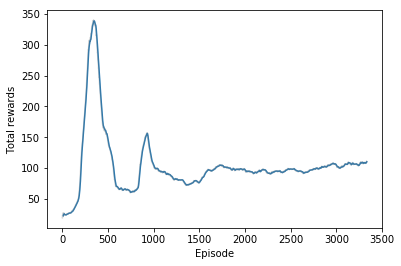

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

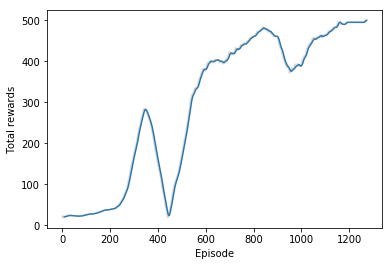

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

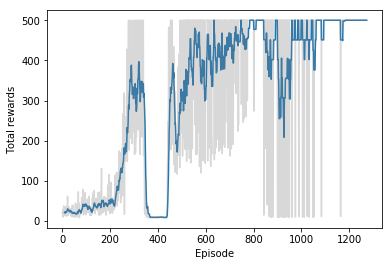

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [18]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [20]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 200.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 11.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.